In [ ]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set
!kaggle datasets download -d splcher/animefacedataset

!unzip cartoon-faces-googles-cartoon-set.zip -d cartoon_faces_dataset
!unzip animefacedataset.zip -d animefacedataset


In [ ]:
!pip install torchsummary

In [ ]:
!pip install torchsummary

import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

anime_faces_path = 'animefacedataset/images'
cartoon_faces_path = 'cartoon_faces_dataset/cartoonset100k_jpg'

class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
 #   transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
    AddGaussianNoise(0., 0.02)
])

class CombinedDataset(Dataset):
    def __init__(self, anime_root, cartoon_root, transform=None):
        self.transform = transform
        self.anime_images = [os.path.join(anime_root, f) for f in os.listdir(anime_root) if f.endswith('.jpg')]
        self.cartoon_images = []
        for folder in ['0', '1', '2', '3', '4']:
            folder_path = os.path.join(cartoon_root, folder)
            self.cartoon_images += [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

        self.anime_images = random.sample(self.anime_images, len(self.anime_images) // 2)
        self.cartoon_images = random.sample(self.cartoon_images, len(self.cartoon_images) // 2)

        self.images = [(img, 0) for img in self.anime_images] + [(img, 1) for img in self.cartoon_images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

combined_dataset = CombinedDataset(anime_faces_path, cartoon_faces_path, transform=transform)
train_size = len(combined_dataset)
train_dataset = combined_dataset

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f'Total combined dataset size: {len(combined_dataset)}')
print(f'Training dataset size: {len(train_dataset)}')


In [ ]:
latent_dim = 32
num_classes = 2

class Encoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
      #  self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 16 * 64 + num_classes, 256)
        self.fc2_mean = nn.Linear(256, latent_dim)
        self.fc2_log_var = nn.Linear(256, latent_dim)

    def forward(self, x, labels):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
     #   x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
      #  x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.flatten(x)
        x = torch.cat([x, labels], dim=1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        z_mean = self.fc2_mean(x)
        z_log_var = self.fc2_log_var(x)
        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + num_classes, 256)
        self.fc2 = nn.Linear(256, 16 * 16 * 64)
      #  self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.final_layer = nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1)

    def forward(self, z, labels):
        z = torch.cat([z, labels], dim=1)
        x = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = x.view(-1, 64, 16, 16)
      #  x = F.leaky_relu(self.deconv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.deconv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.deconv3(x), negative_slope=0.2)
        x = torch.sigmoid(self.final_layer(x))
        return x

class CVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x, labels):
        z_mean, z_log_var = self.encoder(x, labels)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z, labels)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        kl_loss = kl_loss.mean()  
        return reconstructed, kl_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(latent_dim, num_classes).to(device)
decoder = Decoder(latent_dim, num_classes).to(device)
cvae = CVAE(encoder, decoder).to(device)

dummy_images = torch.randn(2, 3, 64, 64).to(device)
dummy_labels = F.one_hot(torch.tensor([0, 1]), num_classes=num_classes).float().to(device)

z_mean, z_log_var = encoder(dummy_images, dummy_labels)
print("Encoder output shapes - z_mean:", z_mean.shape, ", z_log_var:", z_log_var.shape)

z = torch.randn(2, latent_dim).to(device)
reconstructed = decoder(z, dummy_labels)
print("Decoder output shape:", reconstructed.shape)


In [ ]:
reconstruction_loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

losses = []
reconstruction_losses = []
kl_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    total_reconstruction_loss = 0
    total_kl_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = F.one_hot(labels, num_classes=num_classes).float().to(device)
        optimizer.zero_grad()
        reconstructed, kl_loss = cvae(images, labels)
        reconstruction_loss = reconstruction_loss_fn(reconstructed, images)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_loss += kl_loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_reconstruction_loss = total_reconstruction_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    losses.append(avg_loss)
    reconstruction_losses.append(avg_reconstruction_loss)
    kl_losses.append(avg_kl_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f' - Loss: {avg_loss:.4f} - Reconstruction Loss: {avg_reconstruction_loss:.4f} - KL Loss: {avg_kl_loss:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Total Loss')
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


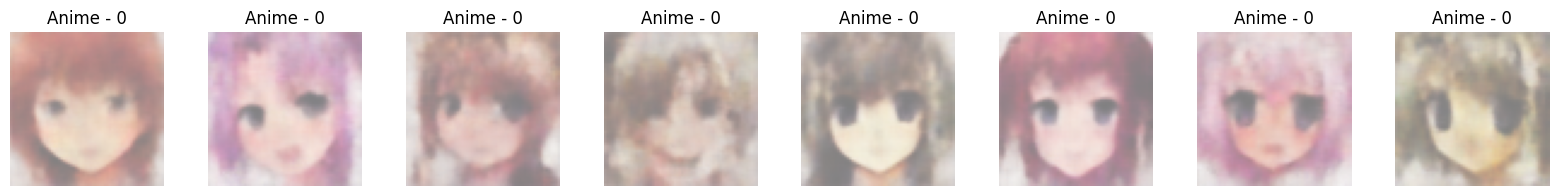

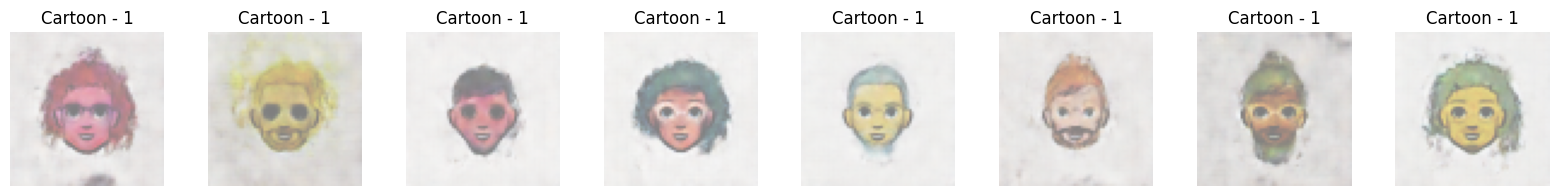

In [55]:
# Generate and display images from the CVAE
def generate_and_display(cvae, label, num_images=8):
    cvae.eval()
    with torch.no_grad():
        labels = torch.tensor([label] * num_images).to(device)
        labels = F.one_hot(labels, num_classes=num_classes).float()
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = cvae.decoder(z, labels)

    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    label_text = 'Anime - 0' if label == 0 else 'Cartoon - 1'
    for i in range(num_images):
        ax = axes[i]
        img = generated_images[i] / 2 + 0.5  # unnormalize
        img = img.cpu().numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_title(label_text, fontsize=12)
        ax.axis('off')
    plt.show()

# Generate images for Anime faces (label 0) and Cartoon faces (label 1)
generate_and_display(cvae, label=0)
generate_and_display(cvae, label=1)


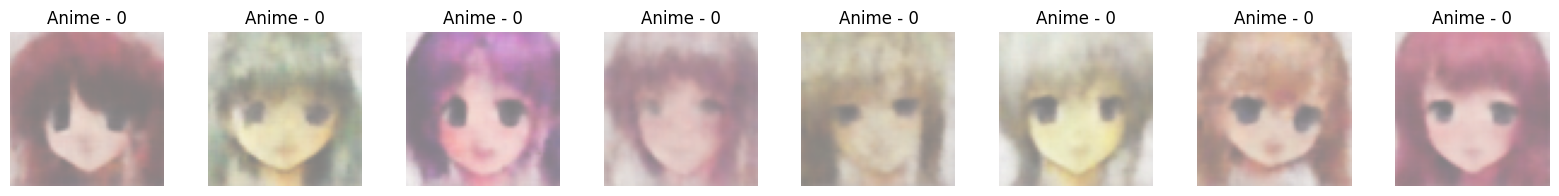

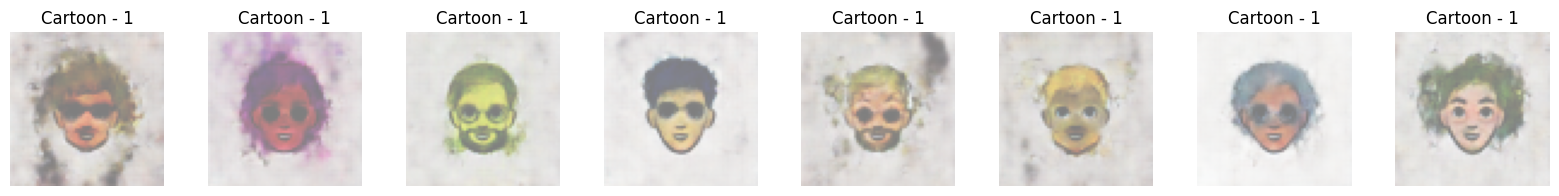

In [123]:
# Generate and display images from the CVAE
def generate_and_display(cvae, label, num_images=8):
    cvae.eval()
    with torch.no_grad():
        labels = torch.tensor([label] * num_images).to(device)
        labels = F.one_hot(labels, num_classes=num_classes).float()
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = cvae.decoder(z, labels)

    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    label_text = 'Anime - 0' if label == 0 else 'Cartoon - 1'
    for i in range(num_images):
        ax = axes[i]
        img = generated_images[i] / 2 + 0.5  # unnormalize
        img = img.cpu().numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_title(label_text, fontsize=12)
        ax.axis('off')
    plt.show()

# Generate images for Anime faces (label 0) and Cartoon faces (label 1)
generate_and_display(cvae, label=0)
generate_and_display(cvae, label=1)
